In [2]:
%load_ext autoreload
%autoreload 2
# Enable imports form top-level of project (edit top_level_path accordingly)
import os
import sys
import inspect

top_level_path = os.path.abspath(os.path.join('..'))
if top_level_path not in sys.path:
	sys.path.append(top_level_path)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from longestpath.gen import gen_num_edges
from benchmarking import RandomParams, Benchmark, new_random_benchmark, Solver, new_graph_file_benchmark, new_benchmark
import re

In [11]:
def generate():
  return [
    gen_num_edges(25, round(25 * degree))
      for degree in np.arange(1, 2.1, 0.1) for _ in range(1)
  ]

params_code = inspect.getsource(generate)
graphs = generate()

benchmark = new_benchmark(graphs, solvers=[
	# Solver("brute", "FAST_BOUND"),
	Solver("kalp"),
	# Solver("brute", "BRUTE_FORCE"),
], params_code = params_code, override_benchmark_path="../benchmarks/test")

benchmark.benchmark_path


'../benchmarks/test(9)'

In [5]:
benchmark = Benchmark.load("../benchmarks/test(4)")

In [12]:
benchmark.run(retryFailures=True, timeout=2)


graph: 0.txt, solver: kalp() ... ✅
length: 18, run_time: 1.5614637320002487
graph: 1.txt, solver: kalp() ... ❌ (timeout)
graph: 2.txt, solver: kalp() ... ❌ (timeout)
graph: 3.txt, solver: kalp() ... ❌ (timeout)
graph: 4.txt, solver: kalp() ... ❌ (timeout)
graph: 5.txt, solver: kalp() ... ❌ (timeout)
graph: 6.txt, solver: kalp() ... ❌ (timeout)
graph: 7.txt, solver: kalp() ... ❌ (timeout)
graph: 8.txt, solver: kalp() ... ❌ (timeout)
graph: 9.txt, solver: kalp() ... ❌ (timeout)
graph: 10.txt, solver: kalp() ... ❌ (timeout)


In [7]:
df = benchmark.get_dataframe()
df

,path,run_time,length,solver,graph_id,solver_name,vertices,edges,average_out_degree
0,"[3, 12, 1, 11, 46, 27, 25, 23, 41, 33]",0.000016,9,0,0,brute('FAST_BOUND'),50,50,1.0
1,"[9, 39, 13, 47, 8, 6, 22, 20]",0.000008,7,0,1,brute('FAST_BOUND'),50,50,1.0
2,"[5, 41, 6, 47, 23, 46, 27]",0.000009,6,0,2,brute('FAST_BOUND'),50,50,1.0
3,"[6, 1, 13, 14, 10, 23, 46, 48, 0]",0.000008,8,0,3,brute('FAST_BOUND'),50,50,1.0
4,"[25, 22, 27, 42, 29, 45, 4, 19, 24, 28]",0.000009,9,0,4,brute('FAST_BOUND'),50,50,1.0
...,...,...,...,...,...,...,...,...,...
1095,"[12, 0, 14, 25, 13, 35, 47, 7, 34, 37, 4, 11, ...",0.015451,31,1,545,brute('BRUTE_FORCE'),50,100,2.0
1096,"[5, 41, 38, 15, 14, 26, 12, 1, 31, 42, 33, 13,...",0.004782,27,1,546,brute('BRUTE_FORCE'),50,100,2.0
1097,"[5, 9, 8, 23, 25, 40, 37, 38, 31, 17, 12, 45, ...",0.010185,37,1,547,brute('BRUTE_FORCE'),50,100,2.0
1098,"[6, 8, 22, 18, 40, 28, 48, 2, 11, 37, 23, 27, ...",0.001299,26,1,548,brute('BRUTE_FORCE'),50,100,2.0


run_time    Axes(0.125,0.11;0.775x0.77)
dtype: object

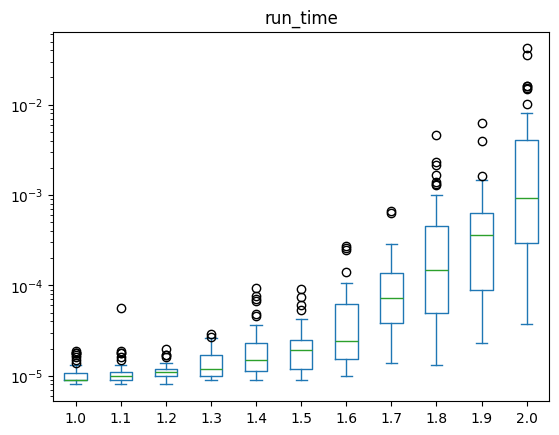

In [15]:
df[df["solver"] == 0][["run_time", "average_out_degree"]].plot.box(by="average_out_degree", logy=True)


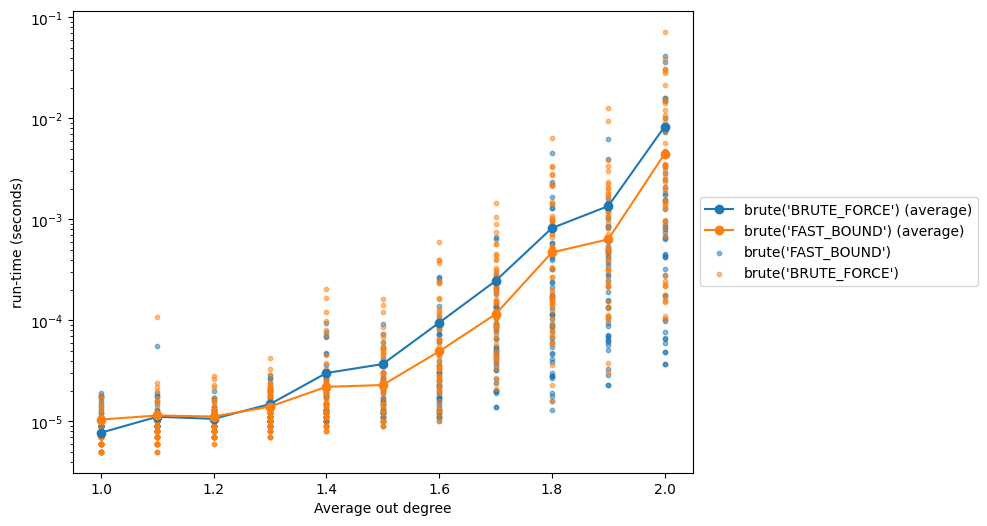

In [14]:
view = df[['average_out_degree', 'solver_name','length', 'run_time']]

to_plot = df.groupby(['average_out_degree', 'solver', 'solver_name']).agg({'run_time': 'mean'}).reset_index() \
    .pivot(index='average_out_degree', columns='solver_name', values='run_time') \
    .rename(columns=lambda x: x + " (average)");


to_plot.plot(style="o-")

for solver_name in benchmark.solver_names():
    solver_df = df[df["solver_name"] == solver_name]  # Select rows where run-time is not null
    plt.scatter(solver_df['average_out_degree'], solver_df['run_time'], label=solver_name, alpha=0.5, s=10)

plt.yscale('log')
# plt.xticks(np.arange(1, 4.0, 0.5))
plt.ylabel("run-time (seconds)")
plt.xlabel("Average out degree")
# plt.title("Longest path solve-time for random directed graphs with 50 vertices")
# plt.axhline(y=0.015, color='black', linestyle='--', label='run-time cutoff', linewidth=1, alpha=0.5, zorder=0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# df[df["solver"] == 0].plot(x = "average_degree", y="run_time", style="--bo", label="solver_name")
# df[df["solver"] == 1].plot(x = "average_degree", y="run_time", style="--bo", label="solver_name")
# plt.ylim(0, to_plot.max().max())

plt.gcf().set_size_inches(8, 6)
plt.savefig(os.path.join(benchmark.benchmark_path, "plot.png"), dpi=400, bbox_inches='tight')

In [10]:
to_plot2 = df.groupby("solver").get_group(0)[["run_time", "average_out_degree"]].sort_values(by="average_out_degree")
to_plot2


,run_time,average_out_degree
0,0.000016,1.0
27,0.000019,1.0
28,0.000010,1.0
29,0.000009,1.0
30,0.000009,1.0
...,...,...
519,0.000682,2.0
520,0.000099,2.0
521,0.000282,2.0
510,0.000178,2.0


<Axes: xlabel='average_out_degree'>

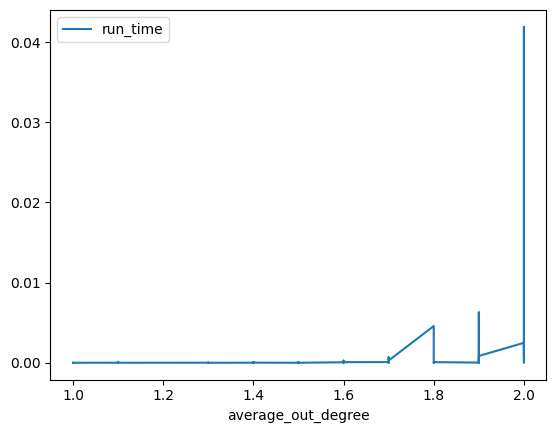

In [11]:
to_plot2.plot(x="average_out_degree", y="run_time")

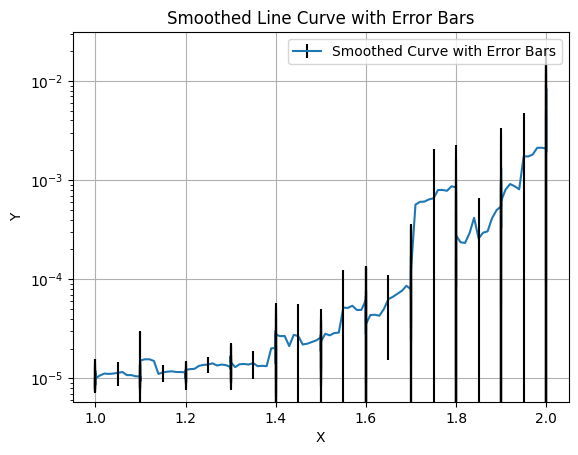

In [12]:
rolling_window = 10
df_smoothed = to_plot2.rolling(rolling_window, center=True).mean()
df_std = to_plot2.rolling(rolling_window, center=True).std()

# Plot the smoothed curve with error bars
plt.errorbar(df_smoothed['average_out_degree'], df_smoothed['run_time'], yerr=df_std['run_time'], label='Smoothed Curve with Error Bars', errorevery=5, barsabove=True, ecolor="black")
plt.xlabel('X')
plt.ylabel('Y')
plt.yscale("log")
plt.title('Smoothed Line Curve with Error Bars')
plt.legend()
plt.grid(True)
plt.show()